In [ ]:
!unzip 'archive.zip'

Archive:  archive.zip
  inflating: labeled_data.csv        


In [ ]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')


In [ ]:
data = pd.read_csv('labeled_data.csv')
data.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


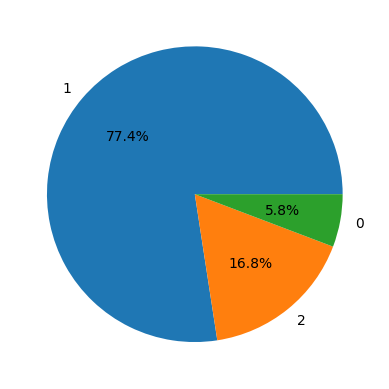

In [ ]:
df = data.iloc[:,-2:]
plt.pie(df['class'].value_counts().values,
        labels = df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [ ]:
df['tweet'] = df['tweet'].str.lower()

# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,class,tweet
0,2,rt mayasolovely as a woman you shouldnt compl...
1,1,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,1,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,1,rt cganderson vivabased she look like a tranny
4,1,rt shenikaroberts the shit you hear about me ...


In [ ]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():

		if word not in stop_words:

			# Let's Lemmatize the word as well
			# before appending to the imp_words list.

			lemmatizer = WordNetLemmatizer()
			lemmatizer.lemmatize(word)

			imp_words.append(word)

	output = " ".join(imp_words)

	return output


df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()


,class,tweet
0,2,rt mayasolovely woman shouldnt complain cleani...
1,1,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,1,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,1,rt cganderson vivabased look like tranny
4,1,rt shenikaroberts shit hear might true might f...


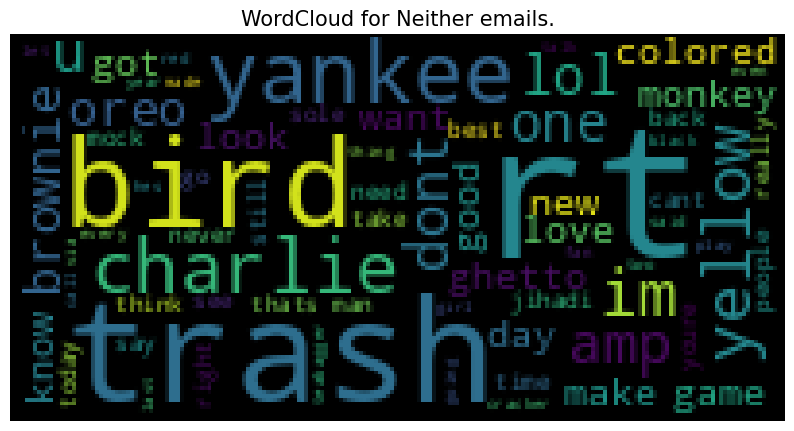

In [ ]:
def plot_word_cloud(data, typ):
  # Joining all the tweets to get the corpus
  email_corpus = " ".join(data['tweet'])

  plt.figure(figsize = (10,10))

  # Forming the word cloud
  wc = WordCloud(max_words = 100,
          width = 200,
          height = 100,
          collocations = False).generate(email_corpus)

  # Plotting the wordcloud obtained above
  plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
  print()

plot_word_cloud(df[df['class']==2], typ='Neither')


In [ ]:
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=3500)
class_0 = df[df['class'] == 0]

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)


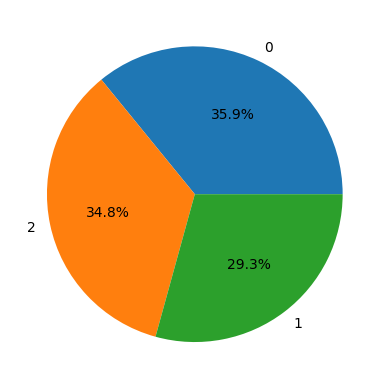

In [ ]:

plt.pie(balanced_df['class'].value_counts().values,
        labels=balanced_df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [ ]:

features = balanced_df['tweet']
target = balanced_df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features,
                                                  target,
                                                  test_size=0.2,
                                                  random_state=22)
X_train.shape, X_val.shape

((9562,), (2391,))

In [ ]:

Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)
Y_train.shape, Y_val.shape

((9562, 3), (2391, 3))

In [ ]:
max_words = 5000
max_len = 100

token = Tokenizer(num_words=max_words,
                  lower=True,
                  split=' ')

token.fit_on_texts(X_train)

In [ ]:
# training the tokenizer
max_words = 5000
token = Tokenizer(num_words=max_words,
				lower=True,
				split=' ')
token.fit_on_texts(X_train)

#Generating token embeddings
Training_seq = token.texts_to_sequences(X_train)
Training_pad = pad_sequences(Training_seq,
							maxlen=100,
							padding='post',
							truncating='post')

Testing_seq = token.texts_to_sequences(X_val)
Testing_pad = pad_sequences(Testing_seq,
							maxlen=100,
							padding='post',
							truncating='post')


In [ ]:
import pickle

# Assuming you have already created and fit the Tokenizer object
# token = Tokenizer(num_words=max_words, lower=True, split=' ')
# token.fit_on_texts(X_train)

# Define the file path where you want to save the Tokenizer object
tokenizer_file_path = "tokenizer.pkl"

# Serialize and save the Tokenizer object using pickle
with open(tokenizer_file_path, 'wb') as file:
    pickle.dump(token, file)

print("Tokenizer saved successfully.")


Tokenizer saved successfully.


In [ ]:
len(Training_pad)
len(Testing_pad)


2391

In [ ]:
model = keras.models.Sequential([
	layers.Embedding(max_words, 32, input_length=max_len),
	layers.Bidirectional(layers.LSTM(16)),
	layers.Dense(512, activation='relu', kernel_regularizer='l1'),
	layers.BatchNormalization(),
	layers.Dropout(0.3),
	layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
			optimizer='adam',
			metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           160000    
                                                                 
 bidirectional (Bidirection  (None, 32)                6272      
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               16896     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

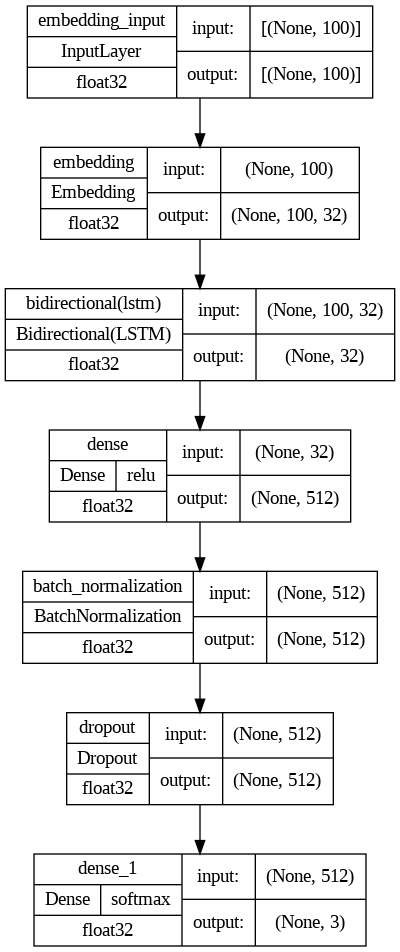

In [ ]:
keras.utils.plot_model(
	model,
	show_shapes=True,
	show_dtype=True,
	show_layer_activations=True
)


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


In [ ]:
# print(len(X_train),len(Y_train))
X_val

23215                                     hoe errbody know
15728    rt jaclyndeeter well maybe youre whore stupid ...
18880    rt deviledlegs drawing organic powdered goats ...
14972    rt defendwallst wow rt 1sleepinggiant whatever...
4862     teampowerstroke hoes hoes nothing something gu...
                               ...                        
21264    trust say jesuschrist would killing faggots ca...
5583                                badnewsbridget lol fag
4325               ovotiluoverdose flossinlawson11 niggers
19746    rt nickpertile oh goodness hate chinese people...
6247     jennybaquing terms like honkey cracker peckerw...
Name: tweet, Length: 2391, dtype: object

In [ ]:
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

9562 9562
2391 2391


In [ ]:
X_train = Training_pad
X_val = Testing_pad
history = model.fit(X_train, Y_train,
					validation_data=(X_val, Y_val),
					epochs=50,
					verbose=1,
					batch_size=32,
					callbacks=[lr, es])


Epoch 1/50
299/299 [==============================] - 37s 104ms/step - loss: 1.7625 - accuracy: 0.7562 - val_loss: 0.9787 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 2/50
299/299 [==============================] - 21s 70ms/step - loss: 0.3583 - accuracy: 0.9047 - val_loss: 0.4846 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 3/50
299/299 [==============================] - 21s 72ms/step - loss: 0.2642 - accuracy: 0.9354 - val_loss: 0.4467 - val_accuracy: 0.8745 - lr: 0.0010
Epoch 4/50
299/299 [==============================] - 22s 73ms/step - loss: 0.2099 - accuracy: 0.9527 - val_loss: 0.6206 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 5/50
299/299 [==============================] - 21s 71ms/step - loss: 0.1858 - accuracy: 0.9588 - val_loss: 0.6079 - val_accuracy: 0.8415 - lr: 0.0010


In [ ]:
tokenizer_file_path = "tokenizer.pkl"

# Deserialize and load the Tokenizer object using pickle
with open(tokenizer_file_path, 'rb') as file:
    token = pickle.load(file)

print("Tokenizer loaded successfully.")

Tokenizer loaded successfully.


In [ ]:
text = [' i will kill you']
Training_seq = token.texts_to_sequences(text)
Training_pad = pad_sequences(Training_seq,
							maxlen=100,
							padding='post',
							truncating='post')
# model.predict(Training_pad)
len(Training_pad)

1

In [ ]:
model.predict(Training_pad)

1/1 [==============================] - 3s 3s/step


array([[0.4580996 , 0.16758502, 0.37431544]], dtype=float32)

In [ ]:
from keras.models import load_model
model1 = load_model('my_model.h5')
res = model1.predict(Training_pad)
res[0]

1/1 [==============================] - 1s 875ms/step


array([0.49150908, 0.03949827, 0.46899268], dtype=float32)

In [ ]:
res[0]

array([0.49150908, 0.03949827, 0.46899268], dtype=float32)

In [ ]:
Y_train

,0,1,2
21627,False,False,True
16069,True,False,False
18085,True,False,False
22430,False,False,True
3699,True,False,False
...,...,...,...
3826,False,True,False
13904,False,True,False
4593,False,False,True
10744,False,True,False


In [ ]:
model.save('model.h5')